In [1]:
from __future__ import print_function
import keras
from keras.models import  Model
from keras.layers import Dense, Dropout, Input, Flatten, PReLU, LeakyReLU
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from time import time
import time as T
import traceback
import logging
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from GA.geneticAlgorithm import GenerationalGA
from GA.parentSelector.parentSelector import RandomParentSelector, LinealOrder, TournamentSelection
from GA.parentSelector.parentSelector import WheelSelection, LinealOrderII
from utils.datamanager import DataManager
#import tensorflow as tf




class Layer(object):
    def __init__(self, units=128, activation='relu', dropout=0):
        self.units = units
        self.posible_activations = ['relu', 'sigmoid', 'tanh', 'elu', 'prelu', 'leakyreLu']
        assert activation in self.posible_activations
        self.activation = activation
        self.dropout = dropout
        self.units_lim = 1024
        self.units_prob = 0.2
        self.act_prob = 0.2
        self.drop_prob = 0.2

    def cross(self, other_layer):
        new_units = self.cross_units(other_layer.units)
        new_activation = self.cross_activation(other_layer.activation)
        new_dropout = self.cross_dropout(other_layer.dropout)
        return Layer(new_units, new_activation, new_dropout)

    def cross_activation(self, other_activation):
        if np.random.rand() > 0.5:
            return self.activation
        return other_activation

    def cross_dropout(self, other_dropout):
        b = np.random.rand()
        return self.dropout * (1 - b) + b * other_dropout

    def cross_units(self, other_units):
        b = np.random.rand()
        return int(self.units * (1 - b) + other_units * b)

    def mutate(self):
        aleatory = np.random.rand(4)
        if aleatory[0] < self.units_prob:
            self.units = np.random.randint(0, self.units_lim)
        if aleatory[1] < self.act_prob:
            self.activation = random.choice(self.posible_activations)
        if aleatory[2] < self.drop_prob:
            self.dropout = np.random.rand()

    def compare(self, other_layer):
        if self.units != other_layer.units:
            return False
        if self.activation != other_layer.activation:
            return False
        if self.dropout != other_layer.dropout:
            return False
        return True

    def self_copy(self):
        return Layer(self.units, self.activation, self.dropout)

    def random_layer(self):
        units = np.random.randint(0, self.units_lim)
        act = random.choice(self.posible_activations)
        drop = np.random.rand()
        return Layer(units, act, drop)

    def __repr__(self):
        return "U:%d|A:%s|D:%0.3f" % (self.units, self.activation, self.dropout)


class Cromosome(object):

    def __init__(self, layers=[], fit=None):
        assert type(layers) == list
        self.n_layers = len(layers)
        self.layers = layers
        self.max_layers = 10
        self.layer_prob = 0.1
        self.fit = None
        self.evaluator = Fitness.get_instance()

    def set_fitness(self, fit):
        self.evaluator = fit

    def random_indiv(self):
        n_layers = np.random.randint(0, self.max_layers)
        layers = [Layer().random_layer() for i in range(n_layers)]
        return Cromosome(layers)

    @staticmethod
    def simple_indiv():
        return Cromosome([Layer()])

    def cross(self, other_cromosome):
        new_layers = []

        if self.n_layers == 0:
            return other_cromosome

        n_intersection = np.random.randint(0, self.n_layers)
        for i in range(self.n_layers):
            if i < n_intersection or i >= other_cromosome.n_layers:
                new_layers.append(self.layers[i].self_copy())
            else:
                try:
                    new_layers.append(self.layers[i].cross(other_cromosome.layers[i - n_intersection]))
                except IndexError:
                    print("Problem with index %d" % i)
                    print("Intersection point at %d" % n_intersection)
                    print(len(self.layers), self.layers)
                    print(len(other_cromosome.layers), other_cromosome.layers)
                    print(len(new_layers), new_layers)
                    raise IndexError
        return Cromosome(new_layers)

    def mutate(self):
        for i in range(self.n_layers):
            self.layers[i].mutate()
        if np.random.rand() < self.layer_prob and self.n_layers < self.max_layers:
            self.layers.append(Layer().random_layer())
            self.n_layers = len(self.layers)

    def equals(self, other_cromosome):
        if self.n_layers != other_cromosome.n_layers:
            return False
        for i in range(self.n_layers):
            if not self.layers[i].compare(other_cromosome.layers[i]):
                return False
        return True

    def __repr__(self):
        rep = ""
        for i in range(self.n_layers):
            rep += "%d - %s \n" % (i, self.layers[i])
        return rep

    def fitness(self):
        return self.evaluator.calc(self)


class Fitness:
    __instance = None

    @staticmethod
    def get_instance():
        """ Static access method. """
        if Fitness.__instance == None:
            Fitness()
        return Fitness.__instance

    def __init__(self):
        """ Virtually private constructor. """
        if Fitness.__instance != None:
            raise Exception("This class is a singleton!")
        else:
            Fitness.__instance = self

    def set_params(self, data, batch_size=128, epochs=100, early_stop=True, reduce_plateau=True, verbose=1):
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stop = early_stop
        self.reduce_plateu = reduce_plateau
        self.verb = verbose
        (self.x_train, self.y_train), (self.x_test, self.y_test), (self.x_val, self.y_val) = data
        self.num_clases = self.y_train.shape[1]
        self.callbacks = []
        if self.early_stop and keras.__version__=='2.2.4':
            #self.run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
            self.callbacks.append(EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True))
        elif self.early_stop:
            self.callbacks.append(EarlyStopping(monitor='val_acc', patience=10))
        if self.reduce_plateu:
            self.callbacks.append(ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, verbose=self.verb))
        return self

    def calc(self, chromosome):
        try:
            model = self.decode(chromosome)
            h = model.fit(self.x_train, self.y_train,
                              batch_size=self.batch_size,
                              epochs=self.epochs,
                              verbose=self.verb,
                              validation_data=(self.x_val, self.y_val),
                              callbacks=self.callbacks)
            score = model.evaluate(self.x_val, self.y_val, verbose=0)
            score_t = model.evaluate(self.x_test, self.y_test, verbose=0)
        except Exception as e:
            score = [0,0]
            score_t = [0,0]
            print("Some Error with gen:")
            print(chromosome)
            logging.error(traceback.format_exc())
            keras.backend.clear_session()
            T.sleep(5)
        if self.verb:
            print('Val loss: %0.4f, Test loss: %0.4f' % (score[0], score_t[0]))
            print('Val accuracy: %0.4f, Test accuracy: %0.4f' % (score[1], score_t[1]))
            self.show_result(h, 'acc')
            self.show_result(h, 'loss')
        return score[1]

    def decode(self, chromosome):

        inp = Input(shape=(28, 28, 1))
        x = Flatten()(inp)
        for i in range(chromosome.n_layers):
            act = chromosome.layers[i].activation
            if act in ['relu', 'sigmoid', 'tanh', 'elu']:
                x = Dense(chromosome.layers[i].units, activation=act)(x)
            elif act == 'prelu':
                x = Dense(chromosome.layers[i].units)(x)
                x = PReLU()(x)
            else:
                x = Dense(chromosome.layers[i].units)(x)
                x = LeakyReLU()(x)
            x = Dropout(chromosome.layers[i].dropout)(x)
        x = Dense(self.num_clases, activation='softmax')(x)

        model = Model(inputs=inp, outputs=x)
        if self.verb:
            model.summary()
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])
                      #options = self.run_opts)
        return model

    def show_result(self, history, metric='acc'):
        epochs = np.linspace(0, len(history.history['acc']) - 1, len(history.history['acc']))
        plt.plot(epochs, history.history['val_%s' % metric], label='validation')
        plt.plot(epochs, history.history[metric], label='train')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.show()

    def calc_mean(self, chromosome, iters=5):
        f = []
        ti = time()
        for i in range(iters):
            f.append(self.calc(chromosome))
        print("Acc: %0.3f" % np.mean(f), np.std(f), np.max(f))
        print("Time elapsed: %0.3f" % (time() - ti))

Using TensorFlow backend.


(9432, 28, 28, 1) train samples
(2359, 28, 28, 1) validation samples
(1991, 28, 28, 1) test samples
Genetic algorithm params:
Number of generations: 40
Population size: 15
num parents: 4
offspring size: 11
1) best fit: 0.988 in batch time: 167.79
5) best fit: 0.990 in batch time: 860.10
9) best fit: 0.990 in batch time: 1285.22
13) best fit: 0.990 in batch time: 1671.46
17) best fit: 0.991 in batch time: 2071.08
21) best fit: 0.991 in batch time: 2629.05
25) best fit: 0.990 in batch time: 3358.72
29) best fit: 0.990 in batch time: 3693.18


ERROR:root:Traceback (most recent call last):
  File "<ipython-input-1-ca441fc58a99>", line 201, in calc
    callbacks=self.callbacks)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training.py", line 1037, in fit
    validation_steps=validation_steps)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training_arrays.py", line 199, in fit_loop
    outs = f(ins_batch)
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 2666, in __call__
    return self._call(inputs)
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 2636, in _call
    fetched = self._callable_fn(*array_vals)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1399, in __call__
    run_metadata_ptr)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 526, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.error

Some Error with gen:
0 - U:755|A:sigmoid|D:0.199 
1 - U:649|A:elu|D:0.900 
2 - U:520|A:leakyreLu|D:0.505 
3 - U:876|A:elu|D:0.424 
4 - U:865|A:tanh|D:0.016 



ERROR:root:Traceback (most recent call last):
  File "<ipython-input-1-ca441fc58a99>", line 201, in calc
    callbacks=self.callbacks)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training.py", line 1037, in fit
    validation_steps=validation_steps)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training_arrays.py", line 199, in fit_loop
    outs = f(ins_batch)
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 2666, in __call__
    return self._call(inputs)
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 2636, in _call
    fetched = self._callable_fn(*array_vals)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1399, in __call__
    run_metadata_ptr)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 526, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.error

Some Error with gen:
0 - U:452|A:relu|D:0.586 
1 - U:631|A:elu|D:0.551 
2 - U:598|A:relu|D:0.559 
3 - U:473|A:elu|D:0.355 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [1] and type float
	 [[{{node training/Adam/zeros_20}} = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [1] values: 0>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-1-ca441fc58a99>", line 201, in calc
    callbacks=self.callbacks)
  File "/usr/local/lib/python3.6/dist

Some Error with gen:
0 - U:885|A:sigmoid|D:0.528 
1 - U:774|A:relu|D:0.573 
2 - U:153|A:leakyreLu|D:0.094 
3 - U:267|A:leakyreLu|D:0.591 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [2] and type float
	 [[{{node dense_5/Const}} = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [2] values: 0 0>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-1-ca441fc58a99>", line 201, in calc
    callbacks=self.callbacks)
  File "/usr/local/lib/python3.6/dist-packag

Some Error with gen:
0 - U:885|A:sigmoid|D:0.601 
1 - U:730|A:prelu|D:0.219 
2 - U:306|A:elu|D:0.601 
3 - U:127|A:relu|D:0.642 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [1] and type float
	 [[{{node training/Adam/zeros_20}} = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [1] values: 0>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-1-ca441fc58a99>", line 201, in calc
    callbacks=self.callbacks)
  File "/usr/local/lib/python3.6/dist

Some Error with gen:
0 - U:808|A:tanh|D:0.018 
1 - U:959|A:elu|D:0.034 
2 - U:344|A:sigmoid|D:0.462 
3 - U:685|A:elu|D:0.134 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [973] and type float
	 [[{{node dense_3/Const}} = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [973] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-1-ca441fc58a99>", line 201, in calc
    callbacks=self.callbacks)
  File "/usr/local/lib/python3.6/di

Some Error with gen:
0 - U:760|A:relu|D:0.335 
1 - U:795|A:sigmoid|D:0.398 
2 - U:973|A:leakyreLu|D:0.060 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [640] and type float
	 [[{{node dense_4/Const}} = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [640] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-1-ca441fc58a99>", line 201, in calc
    callbacks=self.callbacks)
  File "/usr/local/lib/python3.6/di

Some Error with gen:
0 - U:590|A:relu|D:0.723 
1 - U:753|A:prelu|D:0.385 
2 - U:557|A:sigmoid|D:0.487 
3 - U:640|A:relu|D:0.347 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[589,748] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node dense_2/random_uniform/RandomUniform}} = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=219443, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_2/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom 

Some Error with gen:
0 - U:589|A:relu|D:0.397 
1 - U:748|A:relu|D:0.047 
2 - U:270|A:leakyreLu|D:0.175 
3 - U:811|A:relu|D:0.697 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [1] and type float
	 [[{{node training/Adam/zeros_20}} = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [1] values: 0>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-1-ca441fc58a99>", line 201, in calc
    callbacks=self.callbacks)
  File "/usr/local/lib/python3.6/dist

Some Error with gen:
0 - U:885|A:sigmoid|D:0.355 
1 - U:682|A:relu|D:0.505 
2 - U:289|A:leakyreLu|D:0.182 
3 - U:525|A:relu|D:0.634 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[552,459] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node dense_2/random_uniform/RandomUniform}} = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=2423448, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_2/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom

Some Error with gen:
0 - U:552|A:relu|D:0.637 
1 - U:459|A:elu|D:0.505 
2 - U:486|A:elu|D:0.343 
3 - U:769|A:relu|D:0.697 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[552,459] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node dense_2/random_uniform/RandomUniform}} = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=4204570, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_2/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom

Some Error with gen:
0 - U:552|A:relu|D:0.637 
1 - U:459|A:elu|D:0.505 
2 - U:486|A:elu|D:0.343 
3 - U:769|A:relu|D:0.697 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[552,459] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node dense_2/random_uniform/RandomUniform}} = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=282103, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_2/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom 

Some Error with gen:
0 - U:552|A:relu|D:0.637 
1 - U:459|A:elu|D:0.505 
2 - U:486|A:elu|D:0.343 
3 - U:769|A:relu|D:0.697 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[552,459] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node dense_2/random_uniform/RandomUniform}} = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=7816945, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_2/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom

Some Error with gen:
0 - U:552|A:relu|D:0.637 
1 - U:459|A:elu|D:0.505 
2 - U:486|A:elu|D:0.343 
3 - U:769|A:relu|D:0.697 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[500] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node dense_2/bias/Assign}} = Assign[T=DT_FLOAT, _grappler_relax_allocator_constraints=true, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_2/bias, dense_2/Const)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_

Some Error with gen:
0 - U:337|A:prelu|D:0.592 
1 - U:500|A:relu|D:0.360 
2 - U:596|A:sigmoid|D:0.148 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[552,687] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node dense_2/random_uniform/RandomUniform}} = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=7420843, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_2/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom

Some Error with gen:
0 - U:552|A:relu|D:0.637 
1 - U:687|A:elu|D:0.505 
2 - U:494|A:elu|D:0.357 
3 - U:172|A:elu|D:0.297 
4 - U:830|A:prelu|D:0.159 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [924] and type float
	 [[{{node dense_4/Const}} = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [924] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-1-ca441fc58a99>", line 201, in calc
    callbacks=self.callbacks)
  File "/usr/local/lib/python3.6/di

Some Error with gen:
0 - U:552|A:relu|D:0.795 
1 - U:561|A:prelu|D:0.505 
2 - U:696|A:leakyreLu|D:0.626 
3 - U:924|A:elu|D:0.263 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [1] and type float
	 [[{{node training/Adam/zeros_20}} = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [1] values: 0>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-1-ca441fc58a99>", line 201, in calc
    callbacks=self.callbacks)
  File "/usr/local/lib/python3.6/dist

Some Error with gen:
0 - U:808|A:relu|D:0.637 
1 - U:959|A:elu|D:0.437 
2 - U:344|A:sigmoid|D:0.462 
3 - U:619|A:leakyreLu|D:0.598 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [1] and type float
	 [[{{node training/Adam/zeros_20}} = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [1] values: 0>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-1-ca441fc58a99>", line 201, in calc
    callbacks=self.callbacks)
  File "/usr/local/lib/python3.6/dist

Some Error with gen:
0 - U:808|A:relu|D:0.421 
1 - U:959|A:elu|D:0.233 
2 - U:368|A:sigmoid|D:0.505 
3 - U:615|A:sigmoid|D:0.252 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[491,531] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/Variable_2/Assign}} = Assign[T=DT_FLOAT, _grappler_relax_allocator_constraints=true, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/Variable_2, training/Adam/zeros_10)]]
Hint: If you want to see a list of allocated tensors when OOM ha

Some Error with gen:
0 - U:491|A:relu|D:0.730 
1 - U:531|A:relu|D:0.679 
2 - U:267|A:leakyreLu|D:0.246 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [519] and type float
	 [[{{node dense_4/Const}} = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [519] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-1-ca441fc58a99>", line 201, in calc
    callbacks=self.callbacks)
  File "/usr/local/lib/python3.6/di

Some Error with gen:
0 - U:623|A:leakyreLu|D:0.590 
1 - U:561|A:relu|D:0.505 
2 - U:718|A:relu|D:0.739 
3 - U:519|A:elu|D:0.508 
4 - U:413|A:leakyreLu|D:0.740 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[808,194] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node dense_2/random_uniform/RandomUniform}} = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=9770024, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_2/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom

Some Error with gen:
0 - U:808|A:leakyreLu|D:0.437 
1 - U:194|A:elu|D:0.034 
2 - U:492|A:sigmoid|D:0.462 
3 - U:659|A:relu|D:0.627 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor of shape [882,858] and type float
	 [[{{node training/Adam/zeros_10}} = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [882,858] values: [0 0 0...]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-1-ca441fc58a99>", line 201, in calc
    callbacks=self.callbacks)
  File "/usr/

Some Error with gen:
0 - U:885|A:sigmoid|D:0.601 
1 - U:682|A:elu|D:0.698 
2 - U:418|A:relu|D:0.326 
3 - U:752|A:sigmoid|D:0.511 
4 - U:882|A:relu|D:0.096 
5 - U:858|A:leakyreLu|D:0.627 



ERROR:root:Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1292, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1277, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1367, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[387,548] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/Variable_2/Assign}} = Assign[T=DT_FLOAT, _grappler_relax_allocator_constraints=true, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/Variable_2, training/Adam/zeros_10)]]
Hint: If you want to see a list of allocated tensors when OOM ha

Some Error with gen:
0 - U:387|A:relu|D:0.590 
1 - U:548|A:relu|D:0.412 
2 - U:475|A:leakyreLu|D:0.226 

33) best fit: 0.990 in batch time: 5336.43
37) best fit: 0.990 in batch time: 671.44
41) best fit: 0.990 in batch time: 1028.92
Making statistical validation
Logging data:
[0.9910979229497323, 0.9885544723350651, 0.9919457398212881, 0.9902501060781765, 0.9902501060781765]
[0.98558711 0.98643493 0.98813056 0.99152183 0.98643493]
Benchmark score: 0.9876. Winner score: 0.9904
t = 2.3334523779154948
p = 0.04790282317055987
Best Gen ->  0 - U:333|A:relu|D:0.590 
1 - U:534|A:relu|D:0.580 
2 - U:688|A:sigmoid|D:0.484 
3 - U:871|A:leakyreLu|D:0.637 

With Fitness: 0.990


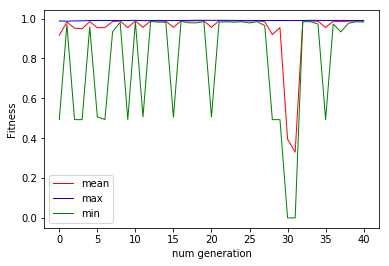

Total elapsed time: 23180.510


In [2]:
l = Layer(516, 'relu', 0.2)
l2 = Layer(516, 'relu', 0.2)
c = Cromosome([l, l2])

ps = {'random':RandomParentSelector(), 'lineal':LinealOrder(), 'wheel':WheelSelection(), 
      'tournament':TournamentSelection(5)}

# params:
dataset = 'mnist'
classes = [4, 9]
parents_selector_key = 'wheel'
num_parents = 0.3
generations = 40
population = 15
maximize_fit = True

# Load data
dm = DataManager(dataset, clases=classes)
data = dm.load_data()
fitness = Fitness.get_instance()
fitness.set_params(data, verbose=0, reduce_plateau=False)

p = ps[parents_selector_key]

ti_all = time()
generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=population, crossover_prob=0.5, mutation_prob=0.7,
                              maximize_fitness=maximize_fit)
winner, best_fit, ranking = generational.evolve()
print("Total elapsed time: %0.3f" % (time() - ti_all))


In [3]:
ps = {'random':RandomParentSelector(), 'lineal':LinealOrder(), 'wheel':WheelSelection(), 
      'tournament':TournamentSelection(5)}

# params:
dataset = 'fashion_mnist'
classes = [0, 1, 2]
parents_selector_key = 'wheel'
num_parents = 0.3
generations = 30
population = 10
maximize_fit = True

# Load data
dm = DataManager(dataset, clases=classes)
data = dm.load_data()
fitness = Fitness.get_instance()
fitness.set_params(data, verbose=0, reduce_plateau=False)

p = ps[parents_selector_key]

ti_all = time()
generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=population, crossover_prob=0.5, mutation_prob=0.7,
                              maximize_fitness=maximize_fit)
winner, best_fit, ranking = generational.evolve()
print("Total elapsed time: %0.3f" % (time() - ti_all))

(14400, 28, 28, 1) train samples
(3600, 28, 28, 1) validation samples
(3000, 28, 28, 1) test samples
Genetic algorithm params:
Number of generations: 30
Population size: 10
num parents: 3
offspring size: 7
1) best fit: 0.976 in batch time: 628.76
4) best fit: 0.973 in batch time: 1143.09
7) best fit: 0.975 in batch time: 1364.07
10) best fit: 0.976 in batch time: 1726.59
13) best fit: 0.975 in batch time: 2049.02
16) best fit: 0.975 in batch time: 1700.61
19) best fit: 0.976 in batch time: 2112.21


KeyboardInterrupt: 

In [ ]:
class A:
    def __init__(self, N_participants=3):
        self.N = N_participants
        self.history_fitness = {}
        
    def set_params(self,maximize, history):
        self.maximize = maximize
        self.history_fitness = history
        
    def eval_individual(self, chrom):
        gen = chrom.__repr__()
        if gen not in self.history_fitness.keys():
            self.history_fitness[gen] = chrom.fitness()
        elif chrom.fit is None:
            chrom.fit = self.history_fitness[gen]
        return chrom.fit
    
    def get_one_offspring(self, population):
        idxs = np.linspace(0, len(population) - 1, len(population)).astype(np.int32)
        idxs_perm = np.random.permutation(idxs)
        participants_1 = [population[idxs_perm[i]] for i in range(self.N)]
        participants_2 = [population[idxs_perm[-i]] for i in range(1, self.N + 1)]
        win_1 = np.argmax([self.eval_individual(chrom) for chrom in participants_1])
        win_2 = np.argmax([self.eval_individual(chrom) for chrom in participants_2])
        parent1 = participants_1[win_1]
        parent2 = participants_2[win_2]
        offspring = parent1.cross(parent2)
        offspring.mutate()
        self.eval_individual(offspring)
        return offspring, (parent1, parent2)
        
    def next_gen(self, population, num_offspring=1):
        next_generation = []
        all_parents = []
        for n in range(num_offspring):
            print(len(population))
            offspring, parents = self.get_one_offspring(population)
            next_generation.append(offspring)
            all_parents.append(parents)
        return next_generation, all_parents
    
class B:
    def __init__(self, n):
        self.n = n
        self.fit = self.n
        
    def __repr__(self):
        return str(self.n)

    def fitness(self):
        return self.n
    
    def cross(self, aB):
        return B(np.mean([self.n, aB.n]))
    
    def mutate(self):
        self.n += np.random.rand()*0
        
a = [0,1,2,3,4,5,6,7,8,9,10]
b = [B(aux) for aux in a]
a_ = LinealOrder()
next_generation, all_parents = a_.next_gen(b, 10000)

In [ ]:
l1 = Layer(10, 'relu', 0.1)
l2 = Layer(20, 'elu', 0.2)
l3 = Layer(30, 'prelu', 0.3)

c1 = Cromosome([l1])
c2 = Cromosome([l2])
c3 = Cromosome([l3])
c12 = Cromosome([l1, l2])
c21 = Cromosome([l2, l1])
c13 = Cromosome([l1, l3])
c31 = Cromosome([l3, l1])
c23 = Cromosome([l2, l3])
c32 = Cromosome([l3, l2])
c123 = Cromosome([l1, l2, l3])
c132 = Cromosome([l1, l3, l2])
c213 = Cromosome([l2, l1, l3])
c231 = Cromosome([l2, l3, l1])
c312 = Cromosome([l3, l1, l2])
c321 = Cromosome([l3, l2, l1])

F = Fitness_str(c321)

population = [c1, c2, c3, c12, c21, c13, c31, c23, c32, c123, c132, c213, c231, c312, c321]
for c in population:
    c.set_fitness(F)
    
population = population[:10]
_=[print(a.fitness(), end=' ') for a in population]
print('\n', F.crom)
print(c321.fitness())

In [ ]:
r = RandomParentSelector(num_offspring=3, history_fitness={}, maximize_fit=True)
next_generation, all_parents = r.next_gen(population)

In [ ]:
print(type(next_generation), len(next_generation), type(all_parents), len(all_parents))
print(next_generation[0], next_generation[0].fitness())
print(all_parents[0][0], all_parents[0][0].fitness())
print(all_parents[0][1], all_parents[0][1].fitness())

In [ ]:
new_pop = r.replace(population, next_generation, all_parents)

In [ ]:
for a , b in zip(new_pop, population):
    print(b)

In [ ]:
class printer:
    def prt(self, objecto):
        print(objecto)
        return
        
class A(object):
    def __init__(self, name, printer):
        self.printer = printer
        self.name = name
        
    def self_print(self):
        self.printer.prt(self)
        
    def __repr__(self):
        return self.name

In [ ]:
p = printer()
p.prt('hi')

a = A('wolo', p)

In [ ]:
a.self_print()

Chromosome to minimize the fuction:

\begin{equation}
f(x) = x \cdot sin(4x) + 1.1  y \cdot sin(2y)
\end{equation}

In [125]:



class chrom:
    def __init__(self, x=0, y=0, mutation_prob=0.2):
        self.x = x
        self.y = y
        self.mut_prob = mutation_prob
        self.fit = None
    
    def set_fitness(self, fit):
        self.evaluator = fit
        
    def random_indiv(self):
        x = 10 * np.random.rand()
        y = 10 * np.random.rand()
        return chrom(x, y)
    
    def simple_indiv(self):
        return chrom(0, 0)
        
    def cross(self, other_cromosome):
        bx = np.random.rand()
        by = np.random.rand()
        x = bx * self.x + (1 - bx) * other_cromosome.x
        y = by * self.y + (1 - by) * other_cromosome.y
        return chrom(x, y)
        
    
    def mutate(self):
        if np.random.rand() < self.mut_prob:
            self.x = 10 * np.random.rand()
        if np.random.rand() < self.mut_prob:
            self.y = 10 * np.random.rand()
            
    def equals(self, other_cromosome):
        return (self.x == other_cromosome.x) and (self.y == other_cromosome.y)
    
    def __repr__(self):
        return "(%0.3f, %0.3f)" % (self.x, self.y)
    
    def fitness(self):
        self.fit = self.x * np.sin(4 * self.x) + 1.1 * self.y * np.sin(2 * self.y)
        return self.fit

In [132]:
pop_size = 12
mut_prob = 0.2
generations = 100
num_parents = 0.5

c = chrom(mutation_prob=mut_prob)
ps = [RandomParentSelector(), LinealOrder(), LinealOrderII(), WheelSelection(), TournamentSelection(5)]
p = ps[2]
generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=pop_size, crossover_prob=0.5,
                              mutation_prob=0.7, maximize_fitness=False, save_pop=True)

winner, best_fit, ranking = generational.evolve(show=False)
print(best_fit)

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Making statistical validation
Logging data:
[-18.49357437534105, -18.49357437534105, -18.49357437534105, -18.49357437534105, -18.49357437534105]
[0. 0. 0. 0. 0.]
Benchmark score: 0.0000. Winner score: -18.4936
t = -inf
p = 0.0
-18.49357437534105


-18.554716504097726 19.861786404025292


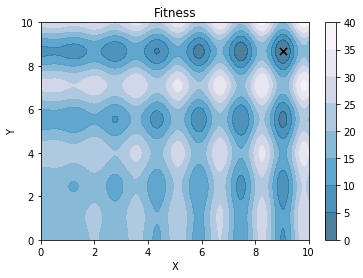

In [138]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import ticker, cm

N = 1000
x = np.linspace(0, 10.0, N)
y = np.linspace(0, 10.0, N)

X, Y = np.meshgrid(x, y)
z = X * np.sin(4 * X) + 1.1 * Y * np.sin(2 * Y) 
print(np.min(z), np.max(z))
z += np.abs(np.min(z))
min_z = np.min(z)
max_z = np.max(z)
max_idxs = []
min_idxs = []
for i in range(N):
    for k in range(N):
        if z[i, k] == min_z:
            min_idxs.append((i, k))
        elif z[i, k] == max_z:
            max_idxs.append((i, k))

# The following is not strictly essential, but it will eliminate
# a warning.  Comment it out to see the warning.
#z = ma.masked_where(z <= 0, z)


# Automatic selection of levels works; setting the
# log locator tells contourf to use a log scale:
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, z, cmap=cm.PuBu_r, alpha = 0.7)
for i, k in max_idxs:
    continue
    plt.scatter(x[k], y[i], c='r', label='max', s=20)
for i, k in min_idxs:
    plt.scatter(x[k], y[i], c='k', label='min', s=50, marker='x')
# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitness')
ax.set_ylim((np.min(Y), np.max(Y)))
cbar = fig.colorbar(cs)
plt.show()

In [122]:
h = generational.population_history
def scatter_pop(h, generation, ax):
    for p in h[generation]:
        ax.scatter(p.x, p.y, c='g', label='min', s=100)
        
print(len(h), generations)

76 75


In [119]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


In [123]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((np.min(X), np.max(X)))
ax.set_ylim((np.min(Y), np.max(Y)))
cs = ax.contourf(X, Y, z, cmap=cm.PuBu_r, alpha = 0.7)
for i, k in min_idxs:
    plt.scatter(x[k], y[i], c='k', label='min', s=100, marker='x')
ax.set_xlabel('X')
ax.set_ylabel('Y')
title = ax.set_title('')
plt.close(fig)
            
def animate2(i):
    ax.cla()
    ax.set_title('generation %s' % str(i).zfill(4))
    cs = ax.contourf(X, Y, z, cmap=cm.PuBu_r, alpha = 0.7)
    for i_, k_ in min_idxs:
        ax.scatter(x[k_], y[i_], c='k', label='min', s=100, marker='x')
    ax.set_xlim((np.min(X), np.max(X)))
    ax.set_ylim((np.min(Y), np.max(Y)))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    scatter_pop(h, i, ax)
    return

In [124]:
anim = animation.FuncAnimation(fig,
                               animate2,
                               init_func=None,
                               frames=generations,
                               interval=100000)

# Set up formatting for the movie files
Writer = animation.writers['imagemagick']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
anim.save('/home/daniel/proyectos/Tesis/project/GA/NeuroEvolution/anim2.gif', writer=writer)

In [ ]:
HTML(anim.to_html5_video())

animation.FuncAnimation?

In [151]:
pop_size = 12
mut_prob = 0.2
generations = 100
num_parents = 0.5
iters = 1000

c = chrom(mutation_prob=mut_prob)

ps = {'random':RandomParentSelector(), 'linealI':LinealOrder(), 'linealII':LinealOrderII(), 
      'wheel':WheelSelection(), 'tournament5': TournamentSelection(5), 'tournament3': TournamentSelection(3)}

all_fits = {}
for key in ps.keys():
    if key == 'wheel':
        continue
    print("Evaluating " + key + "parent selector")
    p = ps[key]
    all_fits[key] = []
    for i in range(iters):
        generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=pop_size, crossover_prob=0.5,
                              mutation_prob=0.7, maximize_fitness=False, save_pop=True,
                              statistical_validation=False)

        winner, best_fit, ranking = generational.evolve(show=False)
        all_fits[key].append(best_fit)



Evaluating randomparent selector
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algor

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6


In [152]:
for key, value in all_fits.items():
    print(key,"score: %0.4f  +-  %0.4f" % (np.mean(value), np.std(value)))

random score: -18.2690  +-  0.5348
linealI score: -18.3858  +-  0.4058
linealII score: -18.3356  +-  0.4231
tournament5 score: -18.3316  +-  0.4547
tournament3 score: -18.3730  +-  0.3838


### Lineal Order I

\begin{equation}
SelectionProb_i = \frac{Position_i}{\sum_{j}{Position_j}}
\end{equation}

### Lineal Order II

\begin{equation}
SelectionProb_i = \frac{N_{keep} - Position_i + 1}{\sum_{j}^{N_{keep}}{Position_j}}
\end{equation}